##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Face Detection with MediaPipe Tasks

This notebook shows you how to use the MediaPipe Tasks Python API to detect faces in images.

## Preparation

Let's start with installing MediaPipe.

In [1]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


Then download an off-the-shelf model. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_detector#models) for more face detection models that you can use.

In [2]:
!wget -q -O detector.tflite -q https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/1/blaze_face_short_range.tflite

## Visualization utilities

To better demonstrate the Face Detector API, we have created a set of visualization tools that will be used in this colab. These will draw a bounding box around detected faces, as well as markers over certain detected points on the faces.

In [3]:
from typing import Tuple, Union
import math
import cv2
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes and keypoints on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  annotated_image = image.copy()
  height, width, _ = image.shape

  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(annotated_image, start_point, end_point, TEXT_COLOR, 3)

    # Draw keypoints
    for keypoint in detection.keypoints:
      keypoint_px = _normalized_to_pixel_coordinates(keypoint.x, keypoint.y,
                                                     width, height)
      color, thickness, radius = (0, 255, 0), 2, 2
      cv2.circle(annotated_image, keypoint_px, thickness, color, radius)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    category_name = '' if category_name is None else category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(annotated_image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return annotated_image

## Download test image

To demonstrate Face Detection, you can download a sample image using the following code. Credits: https://pixabay.com/photos/brother-sister-girl-family-boy-977170/

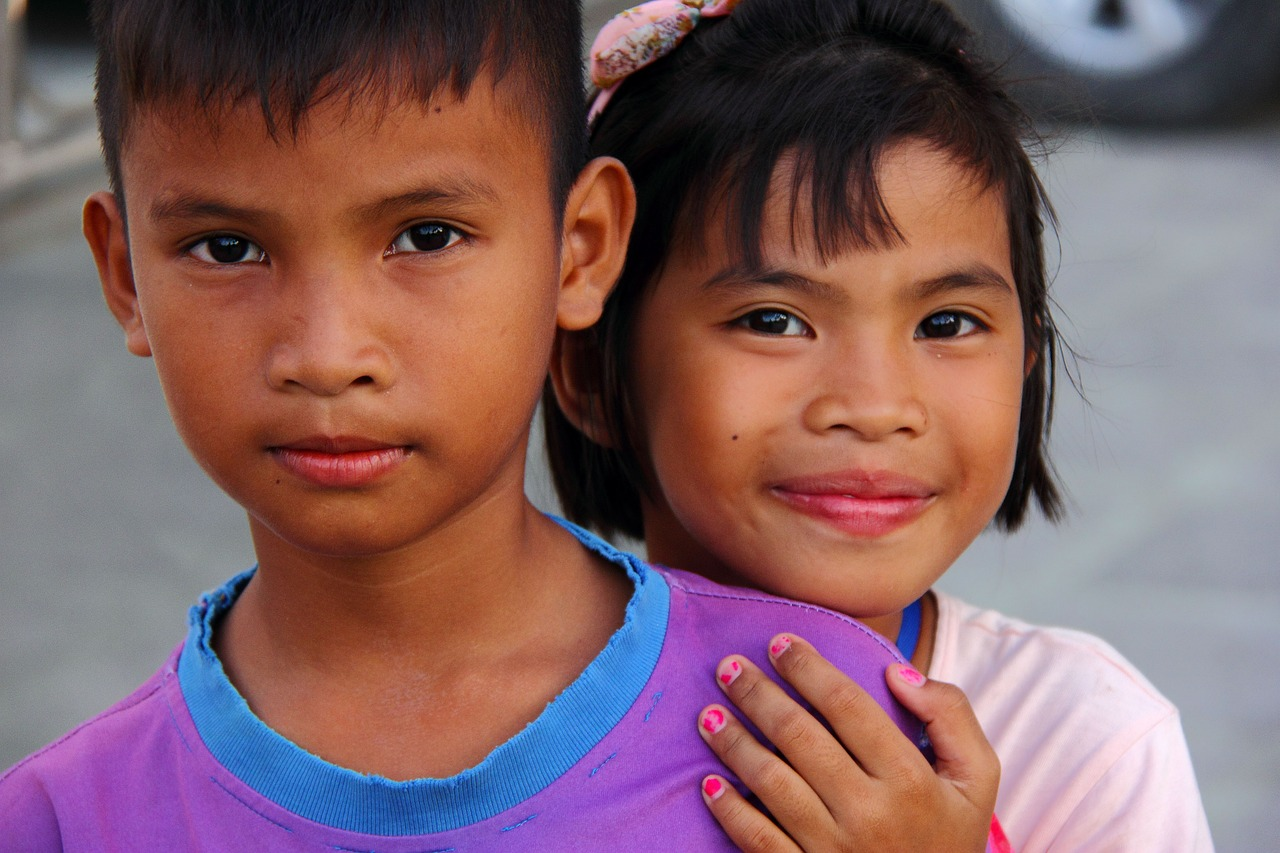

In [4]:
!curl https://i.imgur.com/Vu2Nqwb.jpeg -s -o image.jpg

IMAGE_FILE = 'image.jpg'

import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread(IMAGE_FILE)
cv2_imshow(img)

Optionally, you can upload your own image from your computer. To do this, uncomment the following code cell.

In [5]:
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)

# if len(uploaded.keys()):
#   IMAGE_FILE = next(iter(uploaded))
#   print('Uploaded file:', IMAGE_FILE)

## Running inference and visualizing the results

The final step is to run face detection on your selected image. This involves creating your FaceDetector object, loading your image, running detection, and finally, the optional step of displaying the image with visualizations.

You can check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_detector/python) to learn more about configuration options that this solution supports.

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


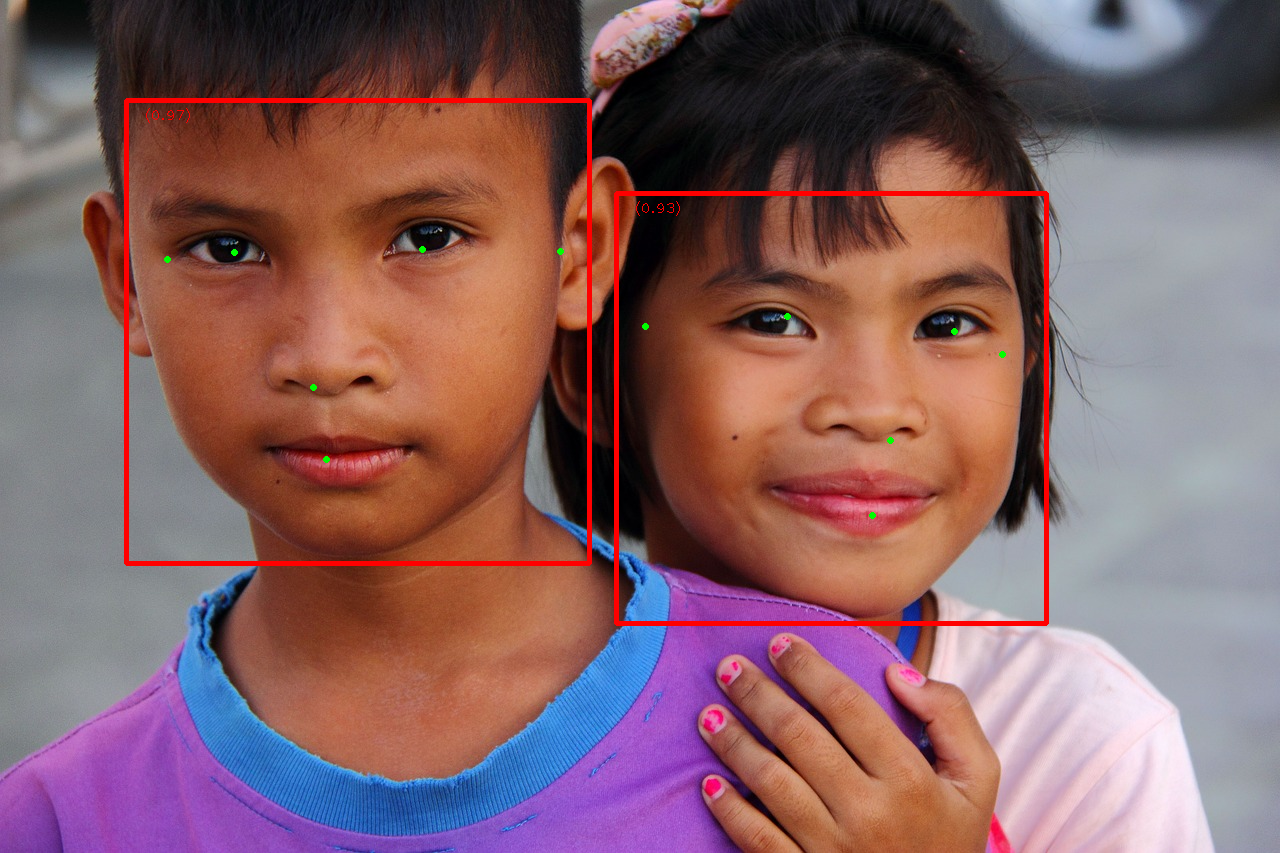

In [6]:
# STEP 1: Import the necessary modules.
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceDetector object.
base_options = python.BaseOptions(model_asset_path='detector.tflite')
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file(IMAGE_FILE)

# STEP 4: Detect faces in the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
cv2_imshow(rgb_annotated_image)

In [73]:
rgb_annotated_image

array([[[105, 110, 119],
        [101, 107, 114],
        [109, 113, 118],
        ...,
        [ 52,  51,  47],
        [ 49,  48,  44],
        [ 50,  49,  45]],

       [[106, 111, 120],
        [105, 111, 118],
        [111, 115, 120],
        ...,
        [ 50,  49,  45],
        [ 48,  47,  43],
        [ 50,  49,  45]],

       [[106, 111, 120],
        [108, 114, 121],
        [113, 117, 122],
        ...,
        [ 53,  50,  46],
        [ 51,  50,  46],
        [ 52,  51,  47]],

       ...,

       [[164,  64, 129],
        [168,  68, 133],
        [163,  63, 129],
        ...,
        [163, 145, 146],
        [163, 145, 146],
        [165, 147, 148]],

       [[161,  61, 126],
        [164,  64, 129],
        [161,  61, 127],
        ...,
        [163, 145, 146],
        [165, 147, 148],
        [166, 148, 149]],

       [[164,  62, 127],
        [165,  63, 128],
        [163,  60, 127],
        ...,
        [162, 143, 146],
        [163, 144, 147],
        [164, 145, 148]]

Cropped face 1


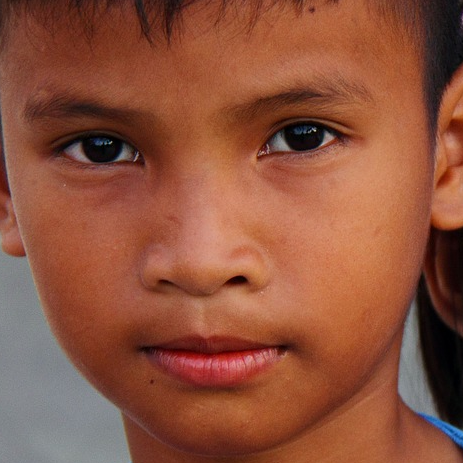

Cropped face 2


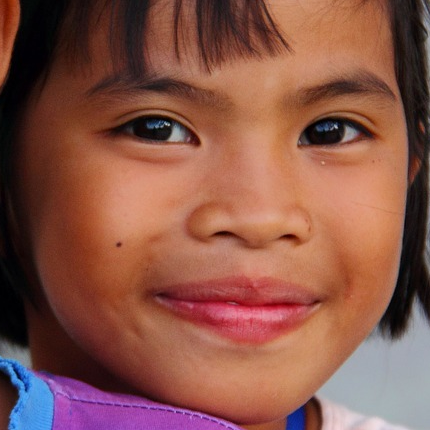

In [35]:
def crop_faces(image, detection_result):
  """Crops the faces found in the image.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualized.
  Returns:
    A list of cropped faces.
  """
  cropped_faces = []
  height, width, _ = image.shape

  for detection in detection_result.detections:
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cropped_face = image[start_point[1]:end_point[1], start_point[0]:end_point[0]]
    cropped_faces.append(cropped_face)

  return cropped_faces

cropped_faces = crop_faces(image_copy, detection_result)

for i, cropped_face in enumerate(cropped_faces):
  print(f"Cropped face {i + 1}")
  cropped_face = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)
  cv2_imshow(cropped_face)

array([[[ 57,  38,  32],
        [ 58,  38,  31],
        [ 65,  38,  31],
        ...,
        [ 58,  49,  50],
        [ 53,  43,  41],
        [ 49,  38,  34]],

       [[ 56,  37,  31],
        [ 58,  35,  29],
        [ 65,  38,  31],
        ...,
        [ 49,  44,  41],
        [ 49,  41,  38],
        [ 44,  35,  30]],

       [[ 56,  35,  30],
        [ 57,  34,  28],
        [ 64,  35,  29],
        ...,
        [ 38,  33,  30],
        [ 41,  33,  30],
        [ 33,  26,  20]],

       ...,

       [[131, 134, 139],
        [130, 133, 138],
        [132, 133, 137],
        ...,
        [122,  68,  56],
        [117,  65,  54],
        [104,  54,  43]],

       [[130, 133, 138],
        [129, 132, 137],
        [131, 132, 136],
        ...,
        [126,  69,  58],
        [118,  64,  52],
        [108,  56,  45]],

       [[130, 133, 138],
        [128, 131, 136],
        [134, 135, 140],
        ...,
        [127,  70,  59],
        [117,  63,  51],
        [111,  59,  48]]], dtype=uint8)
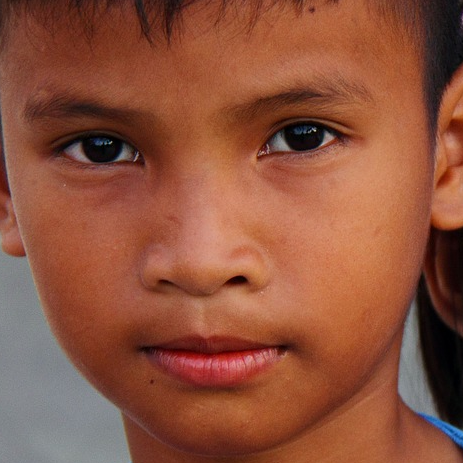

## Emotion Detection    

In [ ]:
!pip install py-feat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.4/381.4 kB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 101.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 76.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  

In [ ]:
from feat import Detector

detector = Detector(
    au_model='xgb'
)

detector

feat.detector.Detector(face_model=retinaface, landmark_model=mobilefacenet, au_model=xgb, emotion_model=resmasknet, facepose_model=img2pose, identity_model=facenet)

In [ ]:
cv2.imwrite(IMAGE_FILE, cv2.cvtColor(rgb_annotated_image, cv2.COLOR_BGR2RGB))

True

In [75]:
detector.detect_image("/content/image.jpg").emotions

100%|██████████| 1/1 [00:05<00:00,  5.74s/it]


anger  disgust      fear  happiness   sadness  surprise   neutral
0  0.014995  0.00137  0.001028   0.001358  0.403222  0.005169  0.572859
1  0.000199  0.00699  0.000758   0.629132  0.005736  0.000288  0.356897